In [4]:
!pip install geopandas

     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.1 MB 325.1 kB/s eta 0:00:04
     - -------------------------------------- 0.0/1.1 MB 325.1 kB/s eta 0:00:04
     - -------------------------------------- 0.0/1.1 MB 325.1 kB/s eta 0:00:04
     - -------------------------------------- 0.0/1.1 MB 325.1 kB/s eta 0:00:04
     - -------------------------------------- 0.0/1.1 MB 325.1 kB/s eta 0:00:04
     - -------------------------------------- 0.0/1.1 MB 325.1 kB/s eta 0:00:04
     - -------------------------------------- 0.0/1.1 MB 325.1 kB/s eta 0:00:04
     - -------------------------------------- 0.0/1.1 MB 81.9 kB/s eta 0:00:13
     - -------------------------------------- 0.0/1.1 MB 81.9 kB/s eta 0:00:1

In [6]:
!pip install geodatasets

     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     -------------------------- ------------- 41.0/60.9 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 641.0 kB/s eta 0:00:00


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("points.csv",)
df

,lon,lat,name
0,110.618321,42.659815,NaN
1,46.237242,55.211574,NaN
2,28.783964,-52.607465,NaN
3,171.321502,-72.809018,NaN
4,-60.461853,-5.002938,NaN
...,...,...,...
109,-8.540295,32.242742,Pharmacie Inas
110,-8.528328,32.246159,Pharmacie Louis Gentil
111,-8.521696,32.247505,YouCode
112,-8.523436,32.248456,Pharmacie Zaid


In [26]:
import geopandas

path_to_data = r"C:\Users\Youcode\Desktop\Carte De Ville\points.csv"
gdf = geopandas.read_file(path_to_data)

gdf.tail(14)


,lon,lat,name,geometry
100,-8.534580869263948,32.24747759816087,Gare de Youssoufia,None
101,-8.534698938621972,32.24351220078192,La Poste,None
102,-8.531801304786967,32.24459529747401,Pharmacie Orphelinat,None
103,-8.534118908621735,32.24585281106933,Pharmacie Al Ouma,None
104,-8.53460069037692,32.24464771790346,Pharmacie MunicipalitÃ©,None
105,-8.533247195318324,32.24580719047216,Pharmacie Kachkat,None
106,-8.535465612109078,32.2418677110458,Pharmacie Ahmar,None
107,-8.537198220485692,32.24158430838614,Pharmacie moderne,None
108,-8.53795365405071,32.23999399206882,Pharmacie Du Souk,None
109,-8.540294868766267,32.24274233875572,Pharmacie Inas,None


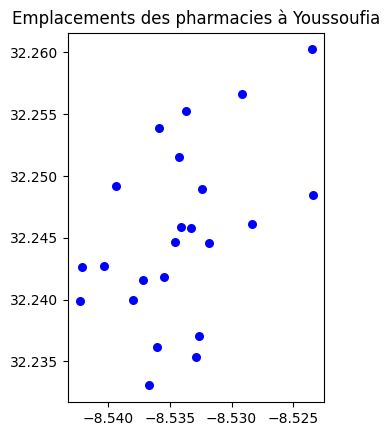

In [45]:
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Définir l'URL de l'API Overpass pour récupérer les données géospatiales
overpass_url = "https://overpass-api.de/api/interpreter"

# Définir la requête Overpass pour Youssoufia avec différents types de points d'intérêt
overpass_query = """
    [out:json];
    area[name="Youssoufia"]->.searchArea;
    (
        node["amenity"="pharmacy"](area.searchArea);
    );
    out center;
"""

# Envoyer la requête à l'API Overpass
response = requests.get(overpass_url, params={'data': overpass_query})

# Vérifier si la requête a réussi (statut 200 indique succès)
if response.status_code == 200:
    # Convertir la réponse JSON en un dictionnaire Python
    data = response.json()
    
    # Créer une liste de dictionnaires contenant les informations sur les pharmacies
    pharmacies_data = []
    for element in data['elements']:
        pharmacy_info = {
            'name': element.get('tags', {}).get('name'),
            'lat': element.get('lat'),
            'lon': element.get('lon')
        }
        pharmacies_data.append(pharmacy_info)
    
    # Créer un GeoDataFrame à partir des données des pharmacies
    gdf = gpd.GeoDataFrame(pharmacies_data, geometry=gpd.points_from_xy([p['lon'] for p in pharmacies_data], [p['lat'] for p in pharmacies_data]))
    
#     # Afficher la carte des pharmacies
#     fig, ax = plt.subplots()
#     gdf.plot(ax=ax, color='blue', markersize=30)
    
#     # Afficher le titre et enlever les axes
#     ax.set_title("Emplacements des pharmacies à Youssoufia")
#     ax.axis('on')
    
    plt.show()
else:
    print("La requête a échoué. Statut :", response.status_code)


L'inconvénient avec cette approche est que si le lieu spécifié n'est pas reconnu, alors, on n'arrive pas à extraire des informations.

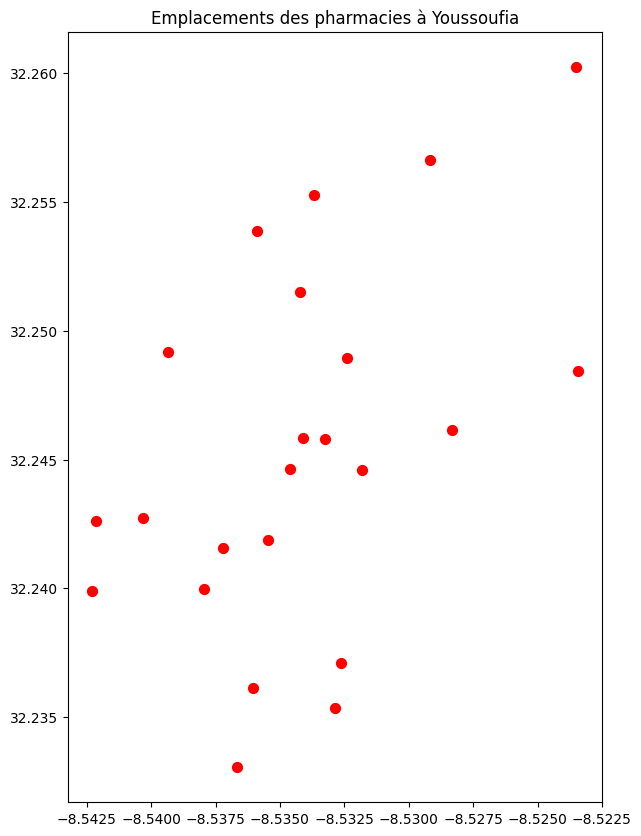

In [52]:
# Afficher la carte des pharmacies avec légende
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='red', markersize=50, legend=True)
    
    # Afficher le titre et enlever les axes
ax.set_title("Emplacements des pharmacies à Youssoufia")
ax.axis('on')
    
plt.show()

In [54]:
!pip install folium


     ---------------------------------------- 0.0/102.3 kB ? eta -:--:--
     ----------------------- --------------- 61.4/102.3 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 102.3/102.3 kB 1.5 MB/s eta 0:00:00


In [56]:
import folium
from shapely.geometry import Point
# Créer une carte Folium
m = folium.Map(location=[gdf['lat'].mean(), gdf['lon'].mean()], zoom_start=14)
    
    # Ajouter les marqueurs des pharmacies sur la carte
for idx, row in gdf.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name']).add_to(m)
    
    # Afficher la carte
m

In [ ]:
!pip install contextily

In [63]:
import contextily as cx


ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, crs=gdf.crs)

ModuleNotFoundError: No module named 'contextily'

In [36]:
!pip install geopandas osmnx


     ---------------------------------------- 0.0/101.4 kB ? eta -:--:--
     -------------------------------------- 101.4/101.4 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     ---- ----------------------------------- 0.2/2.1 MB 5.0 MB/s eta 0:00:01
     --------- ------------------------------ 0.5/2.1 MB 5.1 MB/s eta 0:00:01
     ------------ --------------------------- 0.7/2.1 MB 4.6 MB/s eta 0:00:01
     ----------------- ---------------------- 0.9/2.1 MB 4.8 MB/s eta 0:00:01
     -------------------- ------------------- 1.1/2.1 MB 4.6 MB/s eta 0:00:01
     ------------------------ --------------- 1.3/2.1 MB 4.5 MB/s eta 0:00:01
     ----------------------------- ---------- 1.5/2.1 MB 4.6 MB/s eta 0:00:01
     -------------------------------- ------- 1.7/2.1 MB 4.4 MB/s eta 0:00:01
     ------------------------------------ --- 1.9/2.1 MB 4.5 MB/s eta 0:00:01
     ---------------------------------------  2.1/2.1 MB 4.4 MB/s eta 0:00

In [39]:
import geopandas as gpd
import osmnx as ox

# Télécharger les données OSM de la région d'intérêt (bounding box)
north, south, east, west = 32.2729, 32.2228, -8.5022, -8.5638
G = ox.graph_from_bbox(north, south, east, west, network_type='all_private')

# Convertir les nœuds en GeoDataFrame
nodes_gdf = gpd.GeoDataFrame.from_records(G.nodes(data=True))

# Convertir les arêtes (chemins) en GeoDataFrame
edges_gdf = gpd.GeoDataFrame(G.edges(keys=True, data=True))

# Enregistrer les GeoDataFrames au format GeoJSON ou shapefile si nécessaire
nodes_gdf.to_file("nodes.geojson", driver="GeoJSON")
edges_gdf.to_file("edges.shp", driver="ESRI Shapefile")


KeyError: 0

In [ ]:
# Lecture du fichier GeoJSON contenant les nœuds
nodes_gdf = gpd.read_file("nodes.geojson")

# Lecture du fichier shapefile contenant les arêtes
edges_gdf = gpd.read_file("edges.shp")
